In [1]:
import os
import datetime
import joblib

from tqdm import tqdm

import numpy as np
import pandas as pd

import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
sns.set(
    rc={
        'figure.figsize': (8, 4)
     }
)

# Load Datasets

## purchase records

In [2]:
user_folder = "./训练集/traindata_user"

user_file_ls = os.listdir(user_folder)
user_file_ls = [_file for _file in user_file_ls if _file.startswith("part")]

training_ls = []

for _file in tqdm(user_file_ls):
    training_ls.append(
        pd.read_csv(
            os.path.join(user_folder, _file),
            names=["user_id", "goods_id", "is_click", "is_like", "is_addcart", "is_order", "timestamp", "dt"]
        )
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.52it/s]


In [3]:
purchase = pd.concat(training_ls, ignore_index=True)

In [4]:
purchase.head()

,user_id,goods_id,is_click,is_like,is_addcart,is_order,timestamp,dt
0,5f54b451d18143928b97b7915fcff7e2,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 17:55:03,20230204
1,3ae3bf6c5f5ad2bfac469e5dbf79ac6a,760d021b13388c4f61b56170b1cdff42,1,0,0,0,2023-02-04 17:45:39,20230204
2,8ce414ebafa75feed526a630cc855464,0689e0a5f15b73fd2ed2737d6ca17545,1,0,0,0,2023-02-04 21:42:21,20230204
3,8bcd231a1358d1684a9366b22164662a,abeeece58b49139287b11a5d6112b52a,1,0,0,0,2023-02-04 07:34:45,20230204
4,5e0ae64bc6b3cf5069b4515e26420a33,74159594306e14e9515bbd804b4bab84,1,0,0,0,2023-02-04 08:56:05,20230204


In [5]:
purchase.shape

(7791816, 8)

In [6]:
purchase["user_id"].nunique()

51602

In [7]:
purchase["goods_id"].nunique()

1531577

## items

In [8]:
item_folder = "./训练集/traindata_goodsid"

item_file_ls = os.listdir(item_folder)
item_file_ls = [_file for _file in item_file_ls if _file.startswith("part")]

item_file_ls

['part-00002', 'part-00001', 'part-00000']

In [9]:
item_ls = []

for _file in tqdm(item_file_ls):
    item_ls.append(
        pd.read_csv(
            os.path.join(item_folder, _file),
            names=["goods_id", "category_id", "brand_id"]
        )
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


In [10]:
items = pd.concat(item_ls, ignore_index=True)

In [11]:
items.head()

,goods_id,category_id,brand_id
0,9008b406a45c88d31cacefbe435402c8,1068c6e4c8051cfd4e9ea8072e3189e2,c60a61c10d2a17a26e11e2175ec47740
1,593a2cab5ac5bb9f2ecb8bfe80a6f41a,7d847c831f8f93bbf7bcc6f5bdb67146,7561df74e6902ab1208c6c0f8595f24d
2,8ebfadb015de0b0ee949e545d11daf00,d1c96ae7ab32cffa398efc9912c8a9f2,dff59ee903912aa8e6bdb8bc24dfb69a
3,80084ce8be983ab34cab2abe96a07818,79ea169f7f67d5ca4e93ad3c163e41d4,0f348b9abd09bd11a8331e227c01a48a
4,5d0051a59a88afa2d3c18a4055e26303,0d7de1aca9299fe63f3e0041f02638a3,48956731f24439cdb0d6ad2c5a765080


In [12]:
items.shape

(3465608, 3)

In [13]:
items["goods_id"].nunique()

3465608

In [14]:
items["category_id"].nunique()

1804

In [15]:
items["brand_id"].nunique()

5874

## merge

In [16]:
training = purchase.merge(items, on="goods_id")

training.head()

,user_id,goods_id,is_click,is_like,is_addcart,is_order,timestamp,dt,category_id,brand_id
0,5f54b451d18143928b97b7915fcff7e2,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 17:55:03,20230204,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
1,8c16f8c2d7eaf0966809575411127a44,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 15:41:15,20230204,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
2,163f7872d4ec36de4b2a30d4856fe1cd,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-11 13:14:31,20230211,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
3,ef3e9430956f58d7b96081dffc9ea16e,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-12 20:01:57,20230212,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
4,4c56c88b7ee745e58fb2178495224eea,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-07 22:46:33,20230207,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f


In [17]:
training.shape, purchase.shape

((7791764, 10), (7791816, 8))

In [18]:
training["user_id"].nunique() + training["goods_id"].nunique() + training["category_id"].nunique() + training["brand_id"].nunique()

1589454

In [19]:
training.describe()

,is_click,is_like,is_addcart,is_order,dt
count,7.791764e+06,7.791764e+06,7.791764e+06,7.791764e+06,7.791764e+06
mean,1.058355e+00,1.687166e-02,6.208543e-02,7.392036e-03,2.023022e+07
std,2.777680e-01,1.312817e-01,2.667898e-01,9.054023e-02,2.620875e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023020e+07
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023021e+07
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023022e+07
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023022e+07
max,1.210000e+02,2.200000e+01,2.800000e+01,1.500000e+01,2.023030e+07


In [36]:
unique_ids = []

unique_ids.extend(training["user_id"].unique().tolist())
unique_ids.extend(training["goods_id"].unique().tolist())
unique_ids.extend(training["category_id"].unique().tolist())
unique_ids.extend(training["brand_id"].unique().tolist())

In [38]:
id_map = {}

for idx, _id in enumerate(unique_ids):
    id_map[_id] = idx

In [41]:
len(id_map)

1589454

In [42]:
training["user_id"] = training["user_id"].apply(lambda x: id_map[x])
training["goods_id"] = training["goods_id"].apply(lambda x: id_map[x])
training["category_id"] = training["category_id"].apply(lambda x: id_map[x])
training["brand_id"] = training["brand_id"].apply(lambda x: id_map[x])

In [20]:
training.head()

,user_id,goods_id,is_click,is_like,is_addcart,is_order,timestamp,dt,category_id,brand_id
0,5f54b451d18143928b97b7915fcff7e2,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 17:55:03,20230204,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
1,8c16f8c2d7eaf0966809575411127a44,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 15:41:15,20230204,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
2,163f7872d4ec36de4b2a30d4856fe1cd,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-11 13:14:31,20230211,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
3,ef3e9430956f58d7b96081dffc9ea16e,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-12 20:01:57,20230212,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f
4,4c56c88b7ee745e58fb2178495224eea,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-07 22:46:33,20230207,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f


In [21]:
training.to_csv("./训练集/training_data.csv", index=False)

## test

### items

In [22]:
test_folder = "./测试集a/predict_goods_id"

test_file_ls = os.listdir(test_folder)
test_file_ls = [_file for _file in test_file_ls if _file.startswith("part")]

test_file_ls

['part-00001', 'part-00000']

In [23]:
test_ls = []

for _file in tqdm(test_file_ls):
    test_ls.append(
        pd.read_csv(
            os.path.join(test_folder, _file),
            names=["goods_id"]
        )
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]


In [24]:
test_items = pd.concat(test_ls, ignore_index=True)

In [25]:
test_item_set = set(test_items["goods_id"].unique())
train_item_set = set(purchase["goods_id"].unique())

In [26]:
len(test_item_set), len(train_item_set)

(1367964, 1531577)

In [27]:
# 测试集中有训练集不包含的商品
test_item_set.issubset(train_item_set)

False

In [28]:
len(test_item_set.difference(train_item_set))

456811

### users

In [29]:
test_users = pd.read_excel("./测试集a/a榜需要预测的uid_5000.xlsx")
test_users.head()

,user_id
0,db55512e13c666a67dbfeae200bbb77e
1,6be82d1677c1eacfc615446329fa90b1
2,04672f37371f47e98247e3a426e33d44
3,887343b7ef8d77baed6b2fdfc4b8f536
4,95b336152a9e6aa6130233846ddcfc7a


In [30]:
test_user_set = set(test_users["user_id"].unique())
train_user_set = set(purchase["user_id"].unique())

In [31]:
len(test_user_set), len(train_user_set)

(5000, 51602)

In [33]:
# 测试集用户均在训练集中出现过
test_user_set.issubset(train_user_set)

True

# EDA

In [269]:
training["dt"] = pd.to_datetime(training["dt"], format="%Y%m%d")
training["timestamp"] = pd.to_datetime(training["timestamp"], format="%Y-%m-%d %H:%M:%S")

In [270]:
training.head()

,user_id,goods_id,is_click,is_like,is_addcart,is_order,timestamp,dt,category_id,brand_id,weekday,hour
0,5f54b451d18143928b97b7915fcff7e2,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 17:55:03,2023-02-04,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f,5,17
1,8c16f8c2d7eaf0966809575411127a44,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-04 15:41:15,2023-02-04,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f,5,15
2,163f7872d4ec36de4b2a30d4856fe1cd,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-11 13:14:31,2023-02-11,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f,5,13
3,ef3e9430956f58d7b96081dffc9ea16e,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-12 20:01:57,2023-02-12,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f,6,20
4,4c56c88b7ee745e58fb2178495224eea,7043f055c167b7b27ee8f04ba0613995,1,0,0,0,2023-02-07 22:46:33,2023-02-07,db634857abdceb373ea3fbad4145e1d6,36b058818a9d5058a0ebf3f13080348f,1,22


## 星期一 ~ 星期天每天的样本/点击/收藏/加购/转化量 + 收藏/加购/转化%

In [271]:
training["weekday"] = training.timestamp.dt.weekday

In [272]:
training.columns

Index(['user_id', 'goods_id', 'is_click', 'is_like', 'is_addcart', 'is_order',
       'timestamp', 'dt', 'category_id', 'brand_id', 'weekday', 'hour'],
      dtype='object')

In [273]:
groupby_weekday = (
    training
    .groupby("weekday", as_index=False)
    .agg({"dt": "nunique", "user_id": "count", "is_click": "sum", "is_like": "sum", "is_addcart": "sum", "is_order": "sum"})
    .rename(columns={"user_id": "size", "dt": "num_days"})
)

groupby_weekday["avg_size"] = groupby_weekday["size"] / groupby_weekday["num_days"]
groupby_weekday["avg_click"] = groupby_weekday["is_click"] / groupby_weekday["num_days"]
groupby_weekday["avg_like"] = groupby_weekday["is_like"] / groupby_weekday["num_days"]
groupby_weekday["avg_addcart"] = groupby_weekday["is_addcart"] / groupby_weekday["num_days"]
groupby_weekday["avg_order"] = groupby_weekday["is_order"] / groupby_weekday["num_days"]

groupby_weekday["like_rate"] = groupby_weekday["is_like"] / groupby_weekday["is_click"]
groupby_weekday["addcart_rate"] = groupby_weekday["is_addcart"] / groupby_weekday["is_click"]
groupby_weekday["order_rate"] = groupby_weekday["is_order"] / groupby_weekday["is_addcart"]

groupby_weekday

,weekday,num_days,size,is_click,is_like,is_addcart,is_order,avg_size,avg_click,avg_like,avg_addcart,avg_order,like_rate,addcart_rate,order_rate
0,0,4,1011790,1069946,17368,61389,7475,252947.50,267486.50,4342.00,15347.25,1868.75,0.016233,0.057376,0.121764
1,1,4,1019142,1079168,16686,62983,7712,254785.50,269792.00,4171.50,15745.75,1928.00,0.015462,0.058363,0.122446
2,2,4,992782,1050915,17061,61958,7771,248195.50,262728.75,4265.25,15489.50,1942.75,0.016234,0.058956,0.125424
3,3,4,1016217,1075123,17387,63094,7040,254054.25,268780.75,4346.75,15773.50,1760.00,0.016172,0.058685,0.111580
4,4,5,1523886,1613854,25244,96601,11480,304777.20,322770.80,5048.80,19320.20,2296.00,0.015642,0.059857,0.118839
5,5,4,1124043,1189273,19174,69497,8236,281010.75,297318.25,4793.50,17374.25,2059.00,0.016122,0.058437,0.118509
6,6,4,1103904,1168172,18540,68233,7883,275976.00,292043.00,4635.00,17058.25,1970.75,0.015871,0.058410,0.115531


In [274]:
groupby_weekday_normal = (
    training[training.dt > training.dt.min()]
    .groupby("weekday", as_index=False)
    .agg({"dt": "nunique", "user_id": "count", "is_click": "sum", "is_like": "sum", "is_addcart": "sum", "is_order": "sum"})
    .rename(columns={"user_id": "size", "dt": "num_days"})
)

groupby_weekday_normal["avg_size"] = groupby_weekday_normal["size"] / groupby_weekday_normal["num_days"]
groupby_weekday_normal["avg_click"] = groupby_weekday_normal["is_click"] / groupby_weekday_normal["num_days"]
groupby_weekday_normal["avg_like"] = groupby_weekday_normal["is_like"] / groupby_weekday_normal["num_days"]
groupby_weekday_normal["avg_addcart"] = groupby_weekday_normal["is_addcart"] / groupby_weekday_normal["num_days"]
groupby_weekday_normal["avg_order"] = groupby_weekday_normal["is_order"] / groupby_weekday_normal["num_days"]

groupby_weekday_normal["like_rate"] = groupby_weekday_normal["is_like"] / groupby_weekday_normal["is_click"]
groupby_weekday_normal["addcart_rate"] = groupby_weekday_normal["is_addcart"] / groupby_weekday_normal["is_click"]
groupby_weekday_normal["order_rate"] = groupby_weekday_normal["is_order"] / groupby_weekday_normal["is_addcart"]

groupby_weekday_normal

,weekday,num_days,size,is_click,is_like,is_addcart,is_order,avg_size,avg_click,avg_like,avg_addcart,avg_order,like_rate,addcart_rate,order_rate
0,0,4,1011790,1069946,17368,61389,7475,252947.50,267486.50,4342.00,15347.25,1868.75,0.016233,0.057376,0.121764
1,1,4,1019142,1079168,16686,62983,7712,254785.50,269792.00,4171.50,15745.75,1928.00,0.015462,0.058363,0.122446
2,2,4,992782,1050915,17061,61958,7771,248195.50,262728.75,4265.25,15489.50,1942.75,0.016234,0.058956,0.125424
3,3,4,1016217,1075123,17387,63094,7040,254054.25,268780.75,4346.75,15773.50,1760.00,0.016172,0.058685,0.111580
4,4,4,997090,1055088,16964,61308,7496,249272.50,263772.00,4241.00,15327.00,1874.00,0.016078,0.058107,0.122268
5,5,4,1124043,1189273,19174,69497,8236,281010.75,297318.25,4793.50,17374.25,2059.00,0.016122,0.058437,0.118509
6,6,4,1103904,1168172,18540,68233,7883,275976.00,292043.00,4635.00,17058.25,1970.75,0.015871,0.058410,0.115531


### 样本量

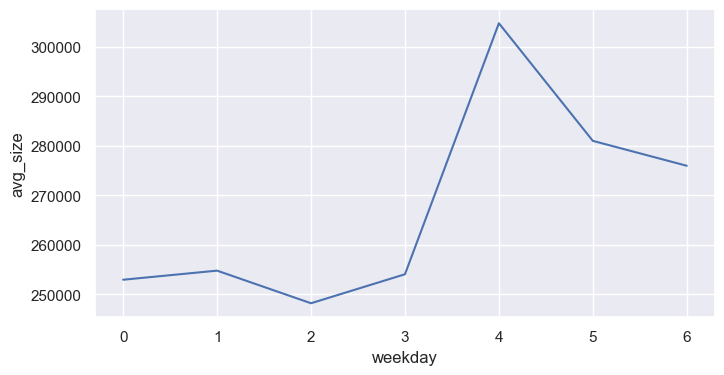

In [275]:
sns.lineplot(data=groupby_weekday, x="weekday", y="avg_size");

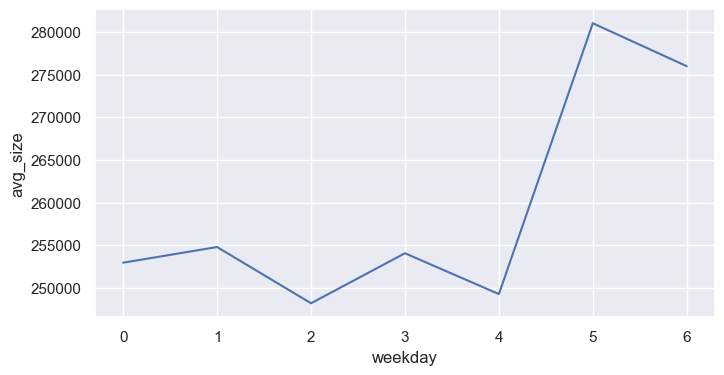

In [276]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="avg_size");

### 点击量

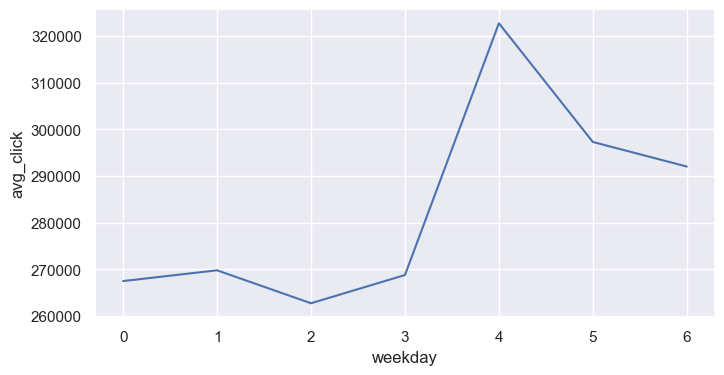

In [277]:
sns.lineplot(data=groupby_weekday, x="weekday", y="avg_click");

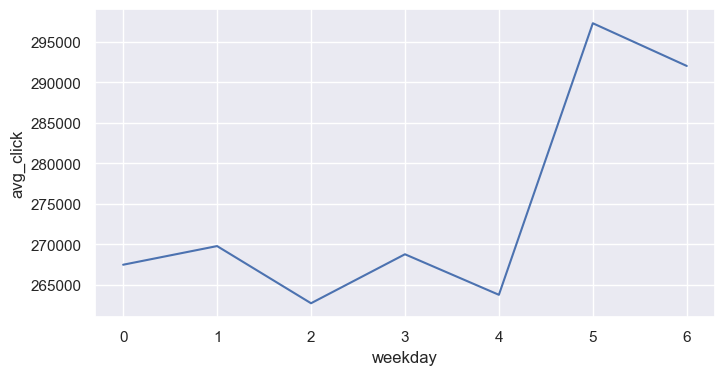

In [278]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="avg_click");

### 收藏量

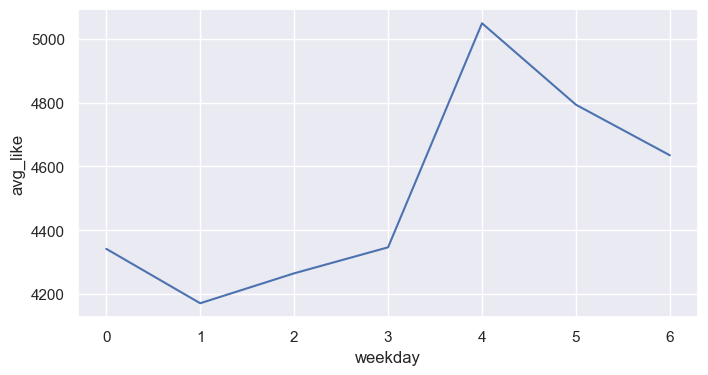

In [279]:
sns.lineplot(data=groupby_weekday, x="weekday", y="avg_like");

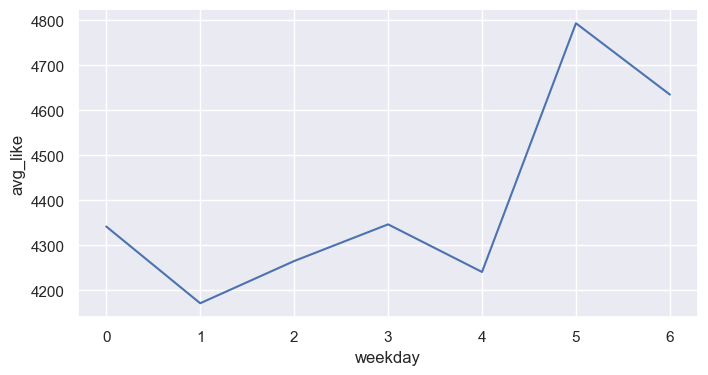

In [280]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="avg_like");

### 加购量

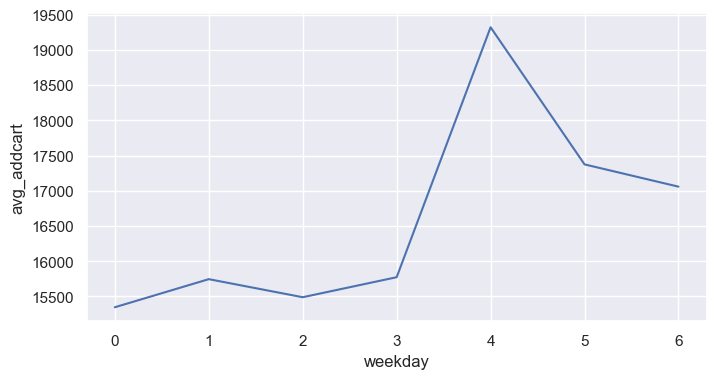

In [281]:
sns.lineplot(data=groupby_weekday, x="weekday", y="avg_addcart");

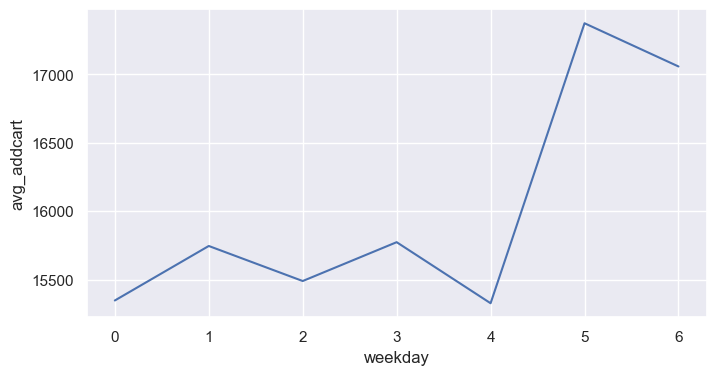

In [282]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="avg_addcart");

### 转化量

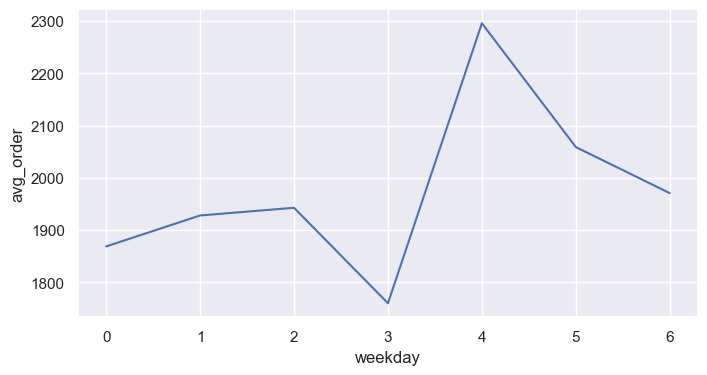

In [283]:
sns.lineplot(data=groupby_weekday, x="weekday", y="avg_order");

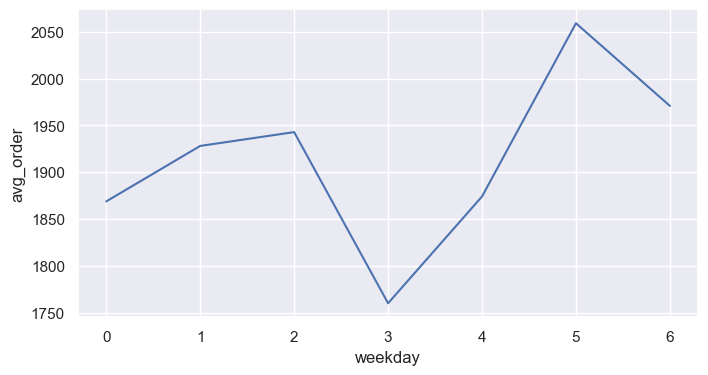

In [284]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="avg_order");

### 收藏率

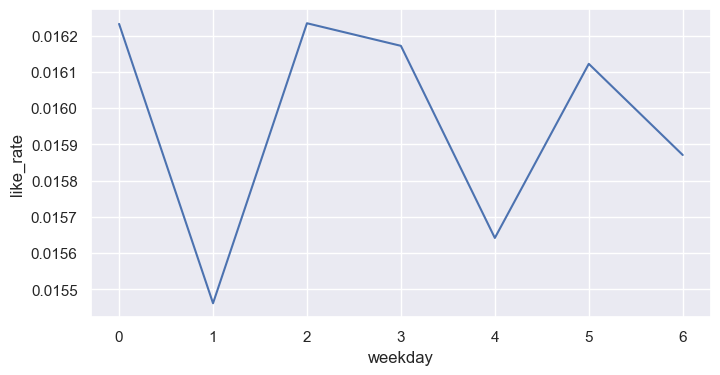

In [285]:
sns.lineplot(data=groupby_weekday, x="weekday", y="like_rate");

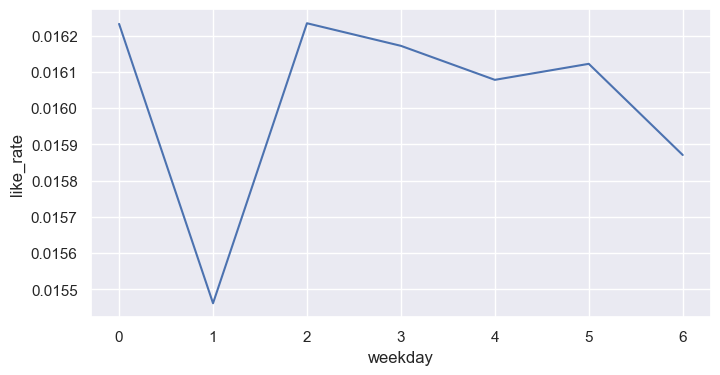

In [286]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="like_rate");

### 加购率

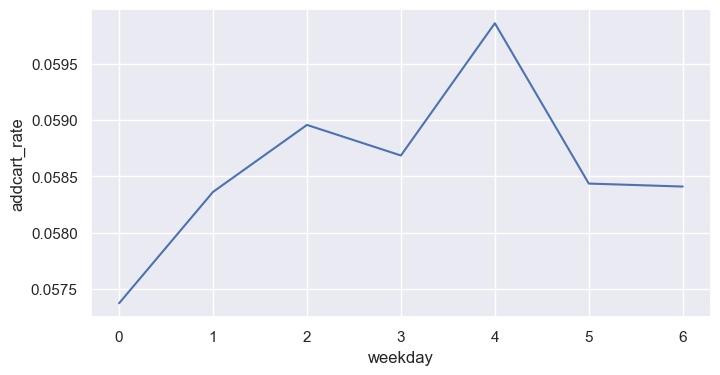

In [287]:
sns.lineplot(data=groupby_weekday, x="weekday", y="addcart_rate");

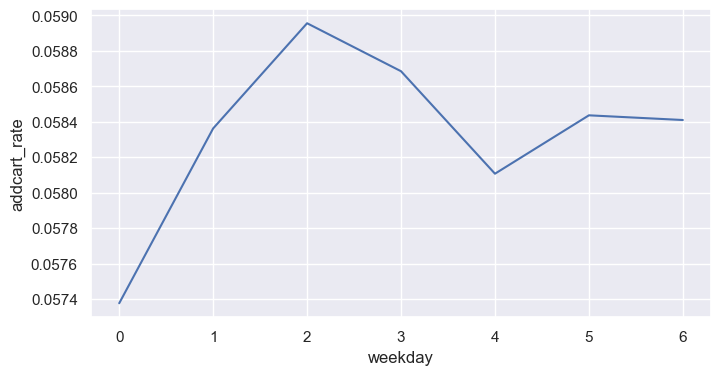

In [288]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="addcart_rate");

### 转化率

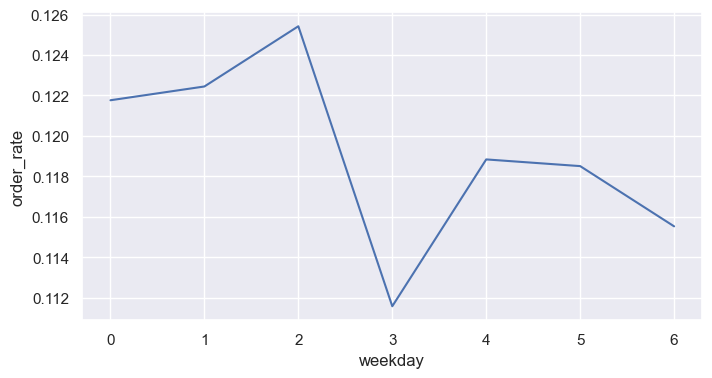

In [289]:
sns.lineplot(data=groupby_weekday, x="weekday", y="order_rate");

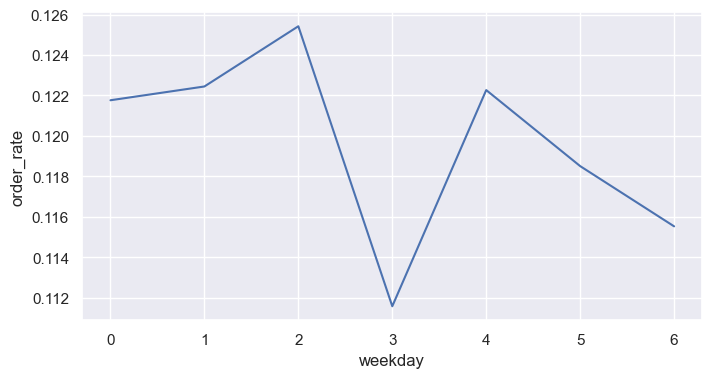

In [290]:
sns.lineplot(data=groupby_weekday_normal, x="weekday", y="order_rate");

## 每天的点击/收藏/加购/转化量 + 收藏/加购/转化%

In [291]:
groupby_dt = (
    training
    .groupby("dt", as_index=False)
    .agg({"user_id": "count", "is_click": "sum", "is_like": "sum", "is_addcart": "sum", "is_order": "sum"})
    .rename(columns={"user_id": "size"})
)

groupby_dt["like_rate"] = groupby_dt["is_like"] / groupby_dt["is_click"]
groupby_dt["addcart_rate"] = groupby_dt["is_addcart"] / groupby_dt["is_click"]
groupby_dt["order_rate"] = groupby_dt["is_order"] / groupby_dt["is_addcart"]

groupby_dt.head()

,dt,size,is_click,is_like,is_addcart,is_order,like_rate,addcart_rate,order_rate
0,2023-02-03,526796,558766,8280,35293,3984,0.014818,0.063162,0.112884
1,2023-02-04,303927,321786,5116,18852,1968,0.015899,0.058586,0.104392
2,2023-02-05,266615,282428,4496,16767,1843,0.015919,0.059367,0.109918
3,2023-02-06,256288,271395,4416,15845,1990,0.016271,0.058384,0.125592
4,2023-02-07,281558,298889,4551,18245,2364,0.015226,0.061043,0.129570


### 样本量

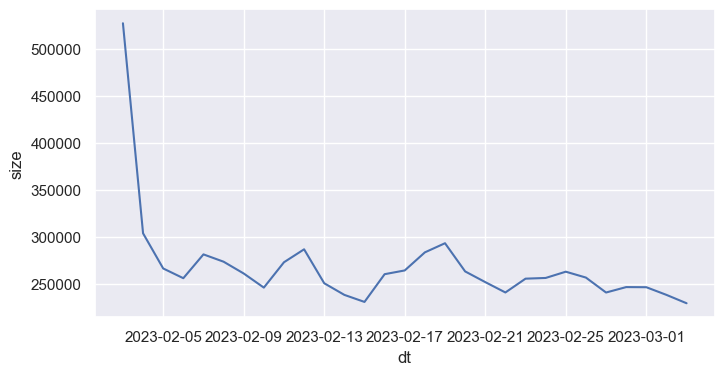

In [292]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="size");

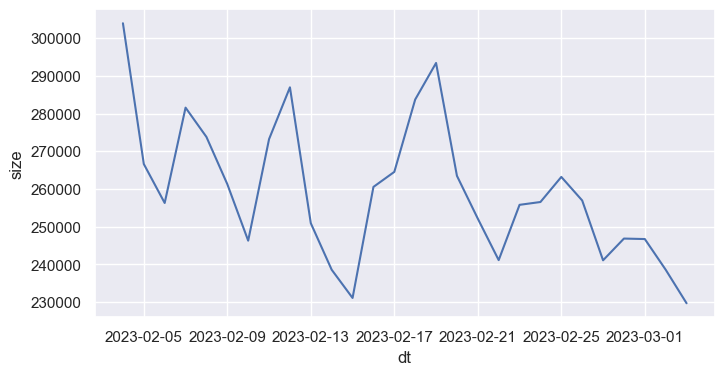

In [293]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="size");

### 点击量

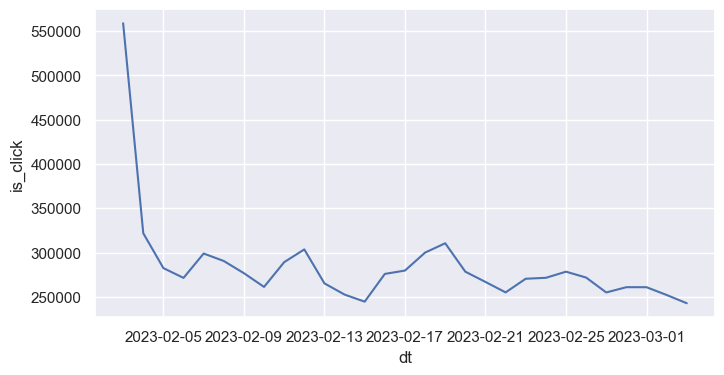

In [294]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="is_click");

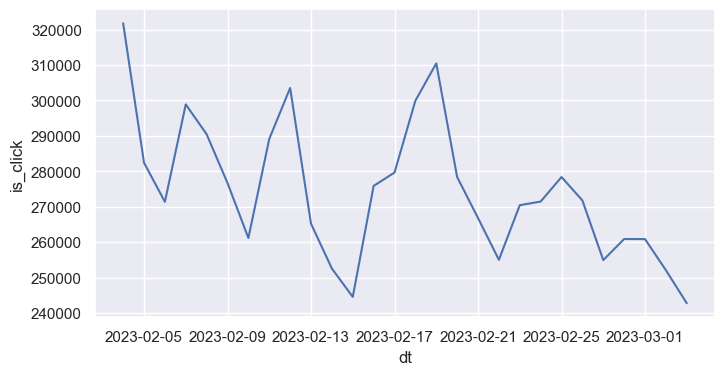

In [295]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="is_click");

### 收藏量

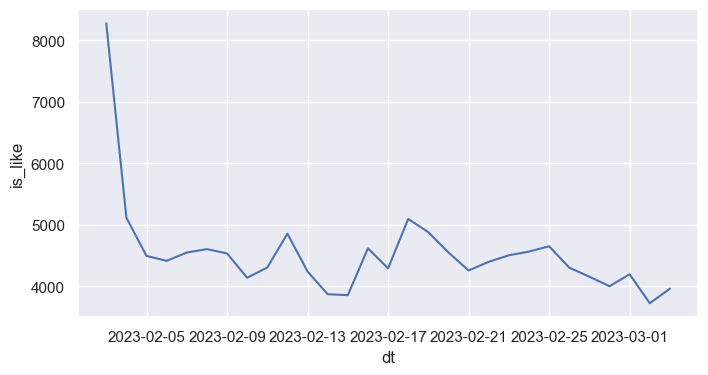

In [296]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="is_like");

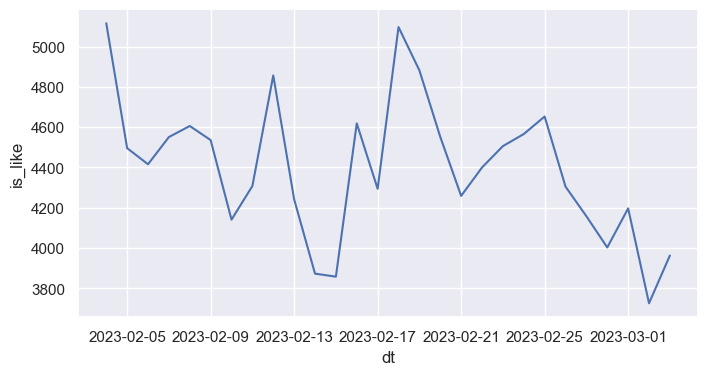

In [297]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="is_like");

### 加购量

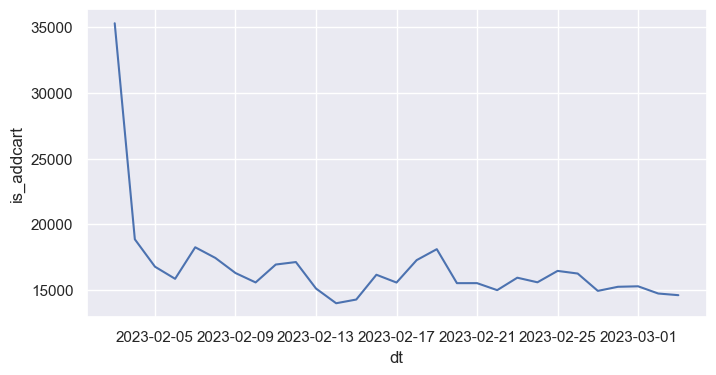

In [298]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="is_addcart");

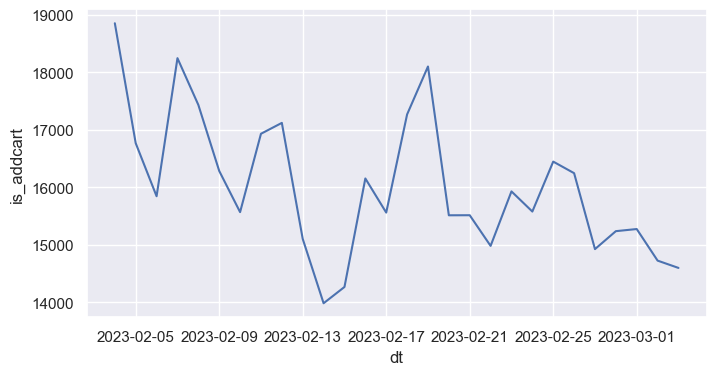

In [299]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="is_addcart");

### 转化量

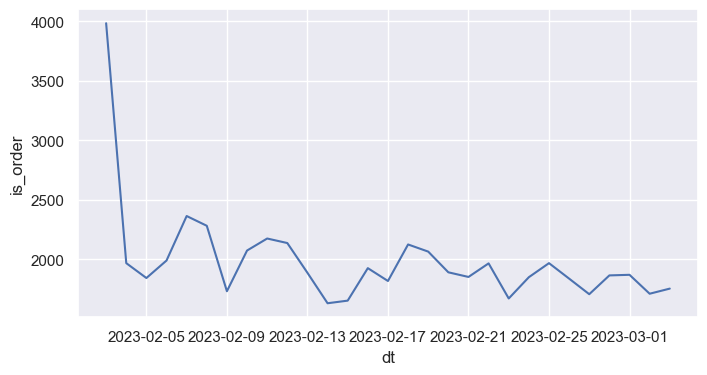

In [300]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="is_order");

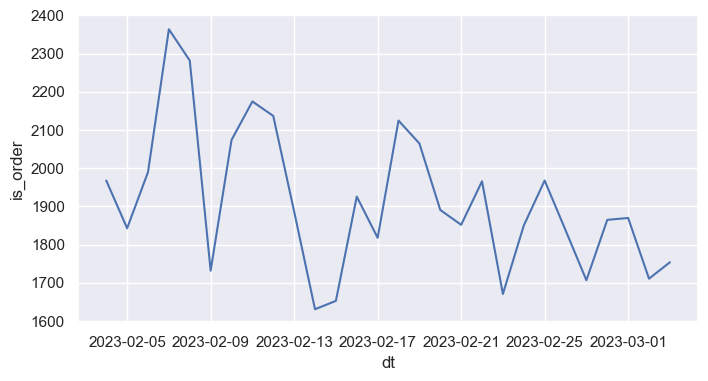

In [301]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="is_order");

### 收藏率

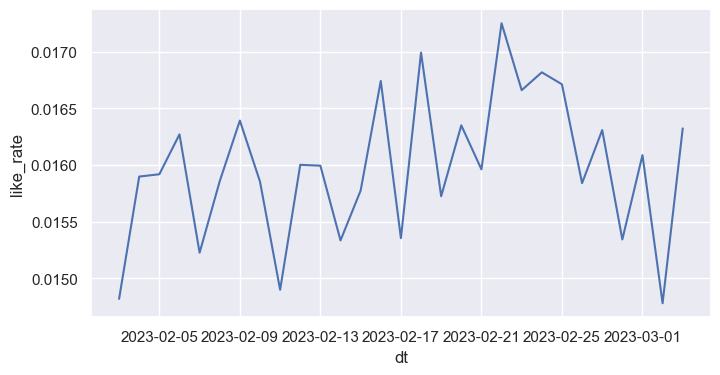

In [302]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="like_rate");

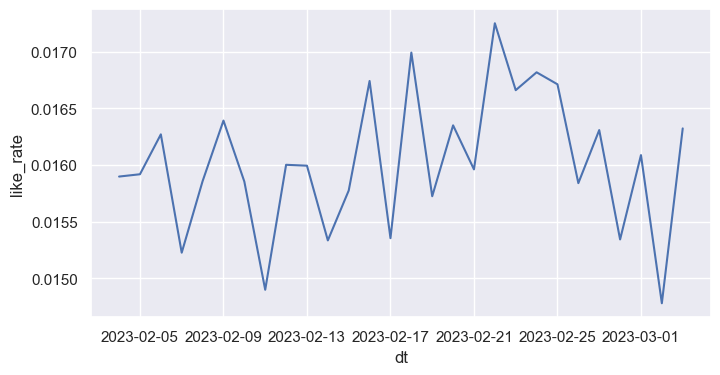

In [303]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="like_rate");

### 加购率

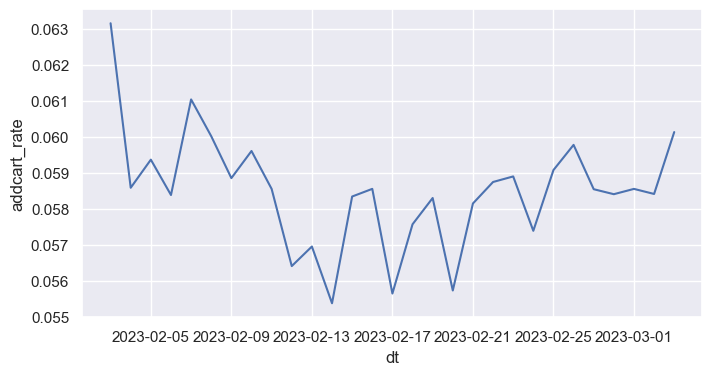

In [304]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="addcart_rate");

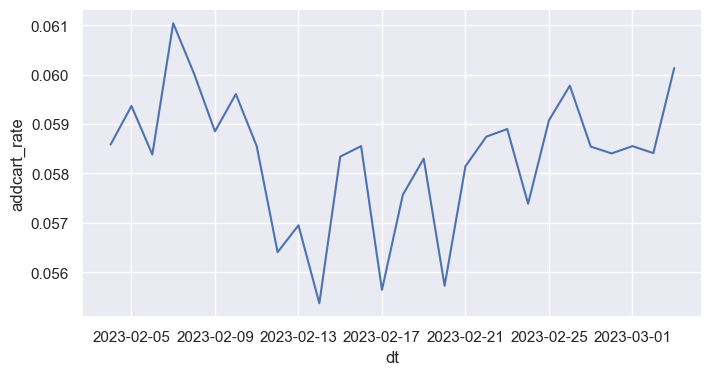

In [305]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="addcart_rate");

### 转化率

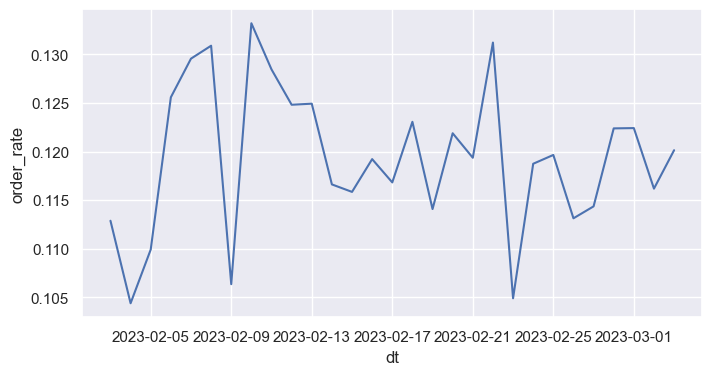

In [306]:
sns.lineplot(data=groupby_dt.loc[:, :], x="dt", y="order_rate");

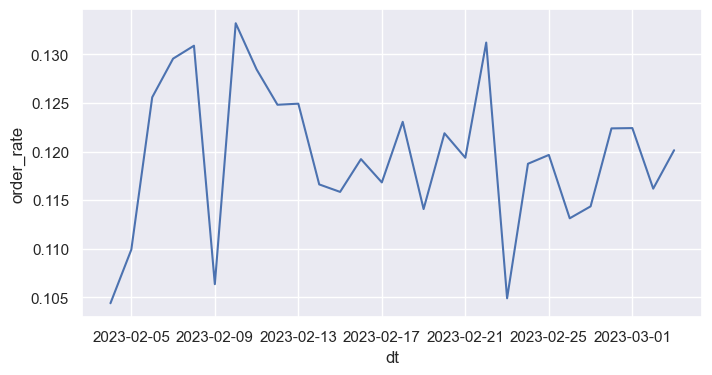

In [307]:
sns.lineplot(data=groupby_dt.loc[1:, :], x="dt", y="order_rate");

## 每小时的点击/收藏/加购/转化量 + 收藏/加购/转化%

In [308]:
training["hour"] = training.timestamp.dt.hour

In [309]:
groupby_hour = (
    training
    .groupby("hour", as_index=False)
    .agg({"dt": "nunique", "user_id": "count", "is_click": "sum", "is_like": "sum", "is_addcart": "sum", "is_order": "sum"})
    .rename(columns={"user_id": "size", "dt": "num_days"})
)

groupby_hour["avg_size"] = groupby_hour["size"] / groupby_hour["num_days"]
groupby_hour["avg_click"] = groupby_hour["is_click"] / groupby_hour["num_days"]
groupby_hour["avg_like"] = groupby_hour["is_like"] / groupby_hour["num_days"]
groupby_hour["avg_addcart"] = groupby_hour["is_addcart"] / groupby_hour["num_days"]
groupby_hour["avg_order"] = groupby_hour["is_order"] / groupby_hour["num_days"]

groupby_hour["like_rate"] = groupby_hour["is_like"] / groupby_hour["is_click"]
groupby_hour["addcart_rate"] = groupby_hour["is_addcart"] / groupby_hour["is_click"]
groupby_hour["order_rate"] = groupby_hour["is_order"] / groupby_hour["is_addcart"]

groupby_hour.head()

,hour,num_days,size,is_click,is_like,is_addcart,is_order,avg_size,avg_click,avg_like,avg_addcart,avg_order,like_rate,addcart_rate,order_rate
0,0,29,269062,284224,4872,16050,2064,9278.000000,9800.827586,168.000000,553.448276,71.172414,0.017141,0.056470,0.128598
1,1,29,124654,131928,2309,7703,942,4298.413793,4549.241379,79.620690,265.620690,32.482759,0.017502,0.058388,0.122290
2,2,29,66892,70942,1285,4303,536,2306.620690,2446.275862,44.310345,148.379310,18.482759,0.018113,0.060655,0.124564
3,3,29,47285,49983,886,2980,330,1630.517241,1723.551724,30.551724,102.758621,11.379310,0.017726,0.059620,0.110738
4,4,29,45122,47707,737,3080,325,1555.931034,1645.068966,25.413793,106.206897,11.206897,0.015448,0.064561,0.105519


In [310]:
groupby_hour_first_day = (
    training[training.dt == training.dt.min()]
    .groupby("hour", as_index=False)
    .agg({"dt": "nunique", "user_id": "count", "is_click": "sum", "is_like": "sum", "is_addcart": "sum", "is_order": "sum"})
    .rename(columns={"user_id": "size", "dt": "num_days"})
)

groupby_hour_first_day["like_rate"] = groupby_hour_first_day["is_like"] / groupby_hour_first_day["is_click"]
groupby_hour_first_day["addcart_rate"] = groupby_hour_first_day["is_addcart"] / groupby_hour_first_day["is_click"]
groupby_hour_first_day["order_rate"] = groupby_hour_first_day["is_order"] / groupby_hour_first_day["is_addcart"]

groupby_hour_first_day.head()

,hour,num_days,size,is_click,is_like,is_addcart,is_order,like_rate,addcart_rate,order_rate
0,0,1,22243,23596,385,1481,197,0.016316,0.062765,0.133018
1,1,1,10377,11023,146,714,68,0.013245,0.064774,0.095238
2,2,1,5349,5695,107,366,24,0.018788,0.064267,0.065574
3,3,1,3288,3430,65,210,26,0.018950,0.061224,0.123810
4,4,1,2689,2864,45,211,23,0.015712,0.073673,0.109005


### 样本量

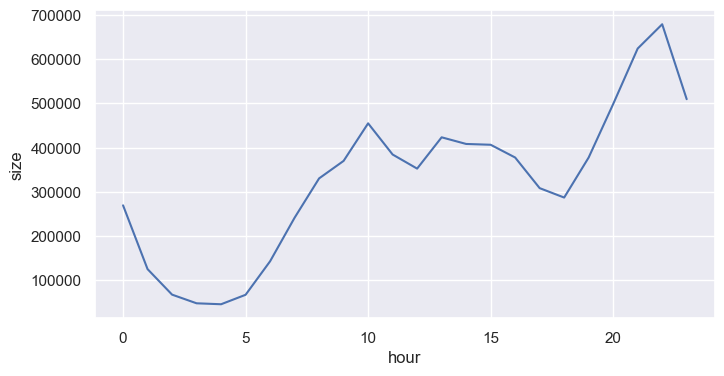

In [311]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="size");

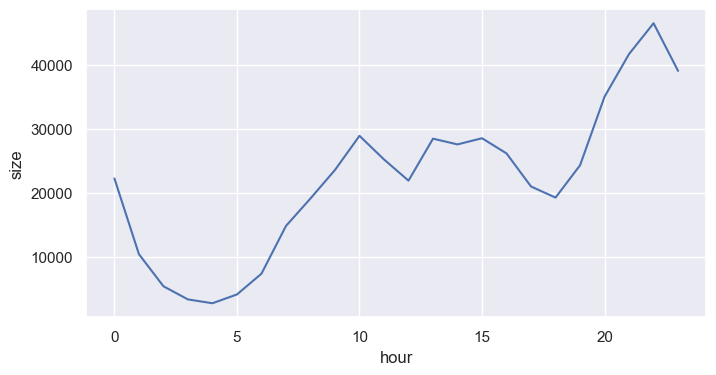

In [312]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="size");

### 点击量

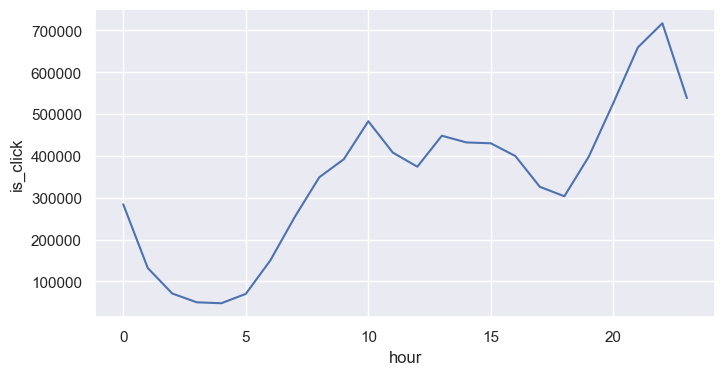

In [313]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="is_click");

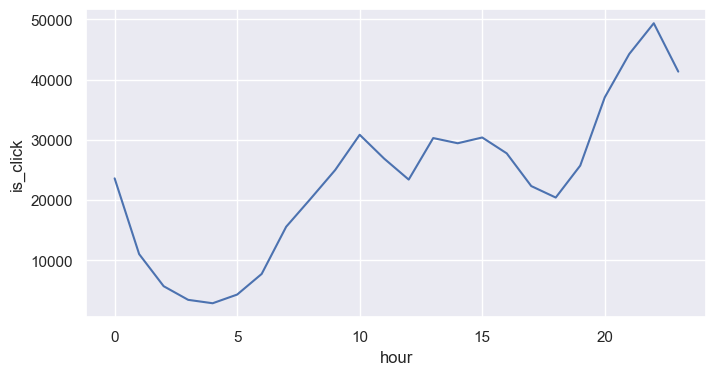

In [314]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="is_click");

### 收藏量

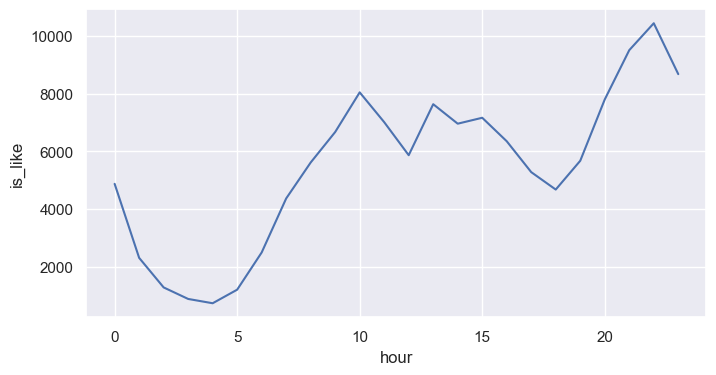

In [315]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="is_like");

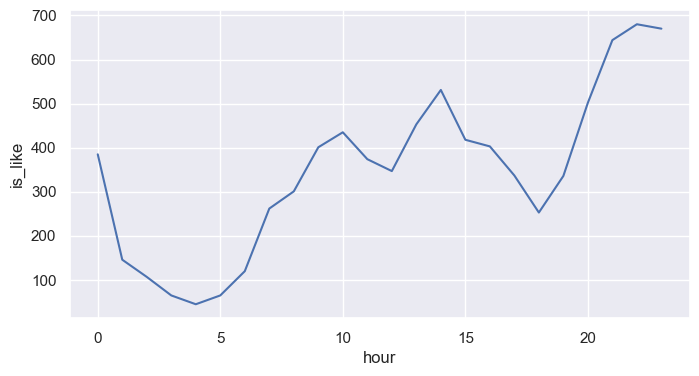

In [316]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="is_like");

### 加购量

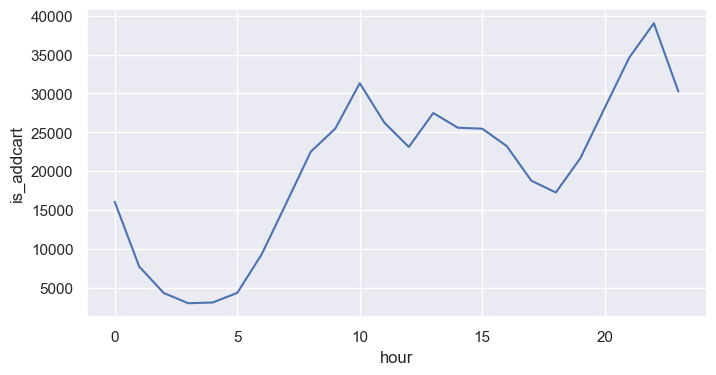

In [317]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="is_addcart");

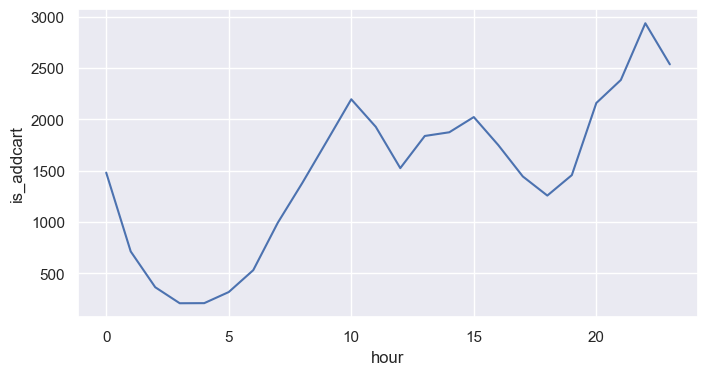

In [318]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="is_addcart");

### 转化量

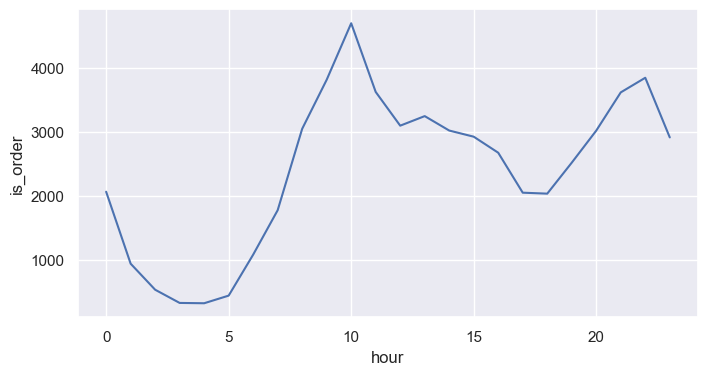

In [319]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="is_order");

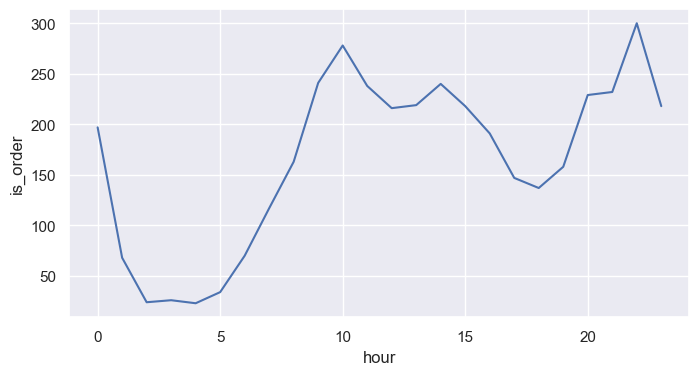

In [320]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="is_order");

### 收藏率

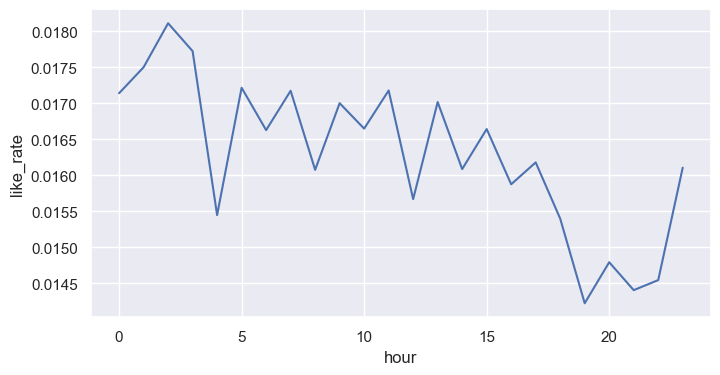

In [321]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="like_rate");

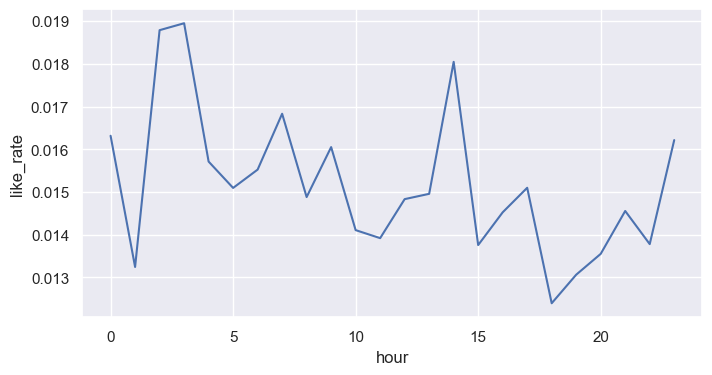

In [322]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="like_rate");

### 加购率

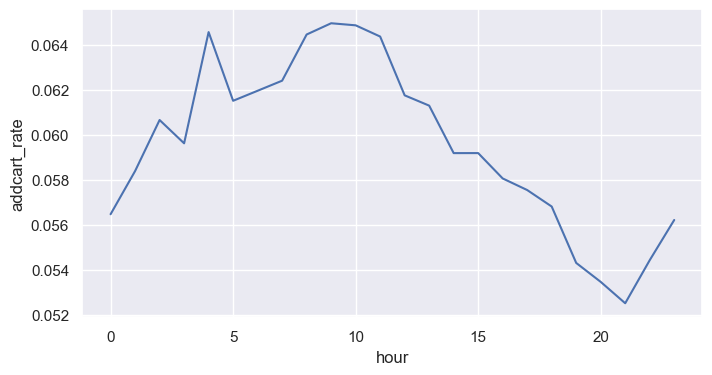

In [323]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="addcart_rate");

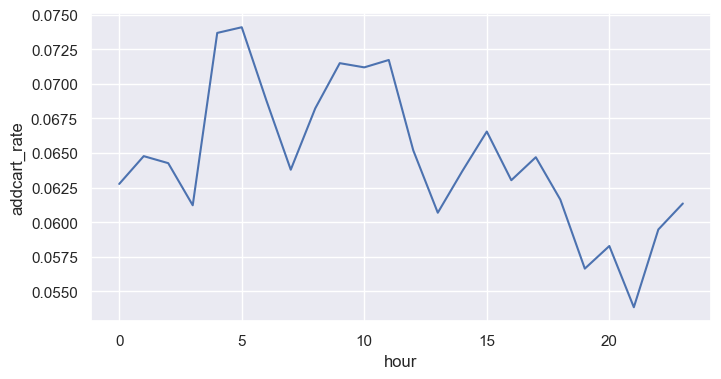

In [324]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="addcart_rate");

### 转化率

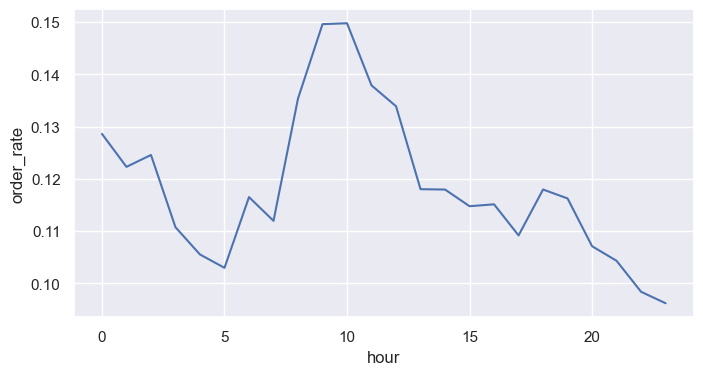

In [325]:
sns.lineplot(data=groupby_hour.loc[:, :], x="hour", y="order_rate");

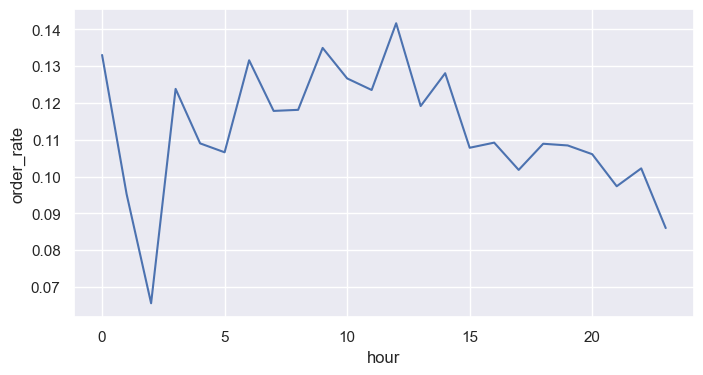

In [326]:
sns.lineplot(data=groupby_hour_first_day.loc[:, :], x="hour", y="order_rate");

## 每人的点击/收藏/加购/转化量

In [327]:
groupby_user = (
    training
    .groupby("user_id", as_index=False)[["is_click", "is_like", "is_addcart", "is_order"]]
    .sum()
)

groupby_user

,user_id,is_click,is_like,is_addcart,is_order
0,0001d0972cc56e776c676d036f3d1a60,261,0,10,0
1,0006db6784957e10ccaf73a1671431ac,27,0,2,0
2,00075bd81f3bd51e107538807e1c6515,14,0,0,0
3,000a9e70cc67c26925d8e0821a908ed8,2,0,0,0
4,000b9499fc7ace86f368dd8eb8e1b486,5,0,0,0
...,...,...,...,...,...
51596,fffd220636f9020f68abbe55626504e9,469,0,59,12
51597,fffd37122c9463da736bbf412c9d0e26,7,0,0,0
51598,fffedfaa8fd18e0b41d4756b1761b479,40,0,3,2
51599,ffff32fb6141c3391f49ff969adfa505,468,48,22,2


In [328]:
groupby_user.describe()

,is_click,is_like,is_addcart,is_order
count,51601.000000,51601.000000,51601.000000,51601.000000
mean,159.811845,2.547625,9.374915,1.116199
std,293.848019,15.239224,21.756308,2.666928
min,1.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,0.000000,0.000000
50%,61.000000,0.000000,3.000000,0.000000
75%,182.000000,0.000000,10.000000,1.000000
max,16308.000000,970.000000,1286.000000,96.000000


### 点击量

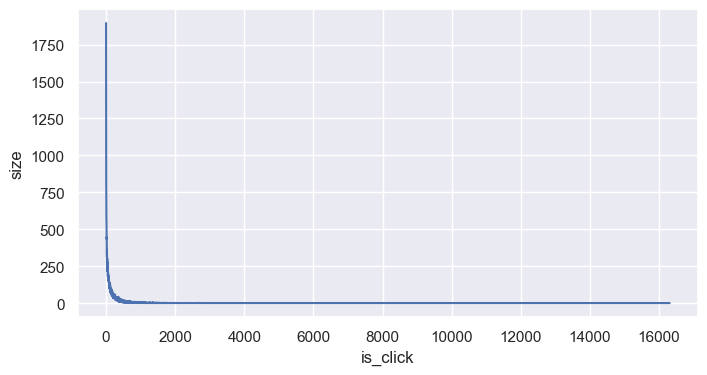

In [329]:
sns.lineplot(
    data=groupby_user.groupby("is_click", as_index=False).size().loc[:, :],
    x="is_click",
    y="size"
);

### 收藏量

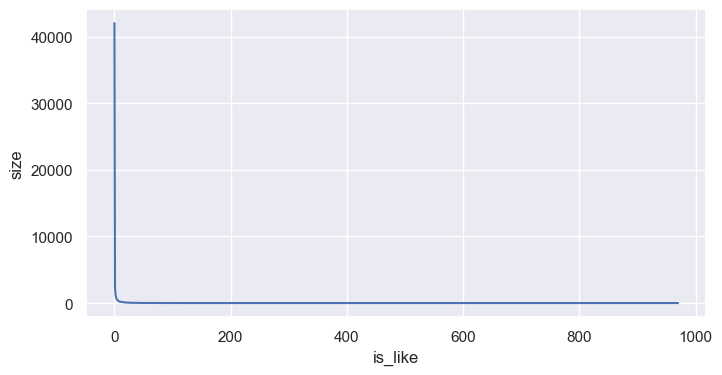

In [330]:
sns.lineplot(
    data=groupby_user.groupby("is_like", as_index=False).size().loc[:, :],
    x="is_like",
    y="size"
);

### 加购量

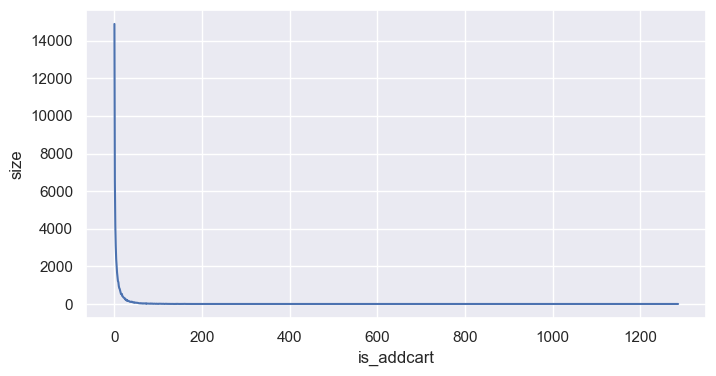

In [331]:
sns.lineplot(
    data=groupby_user.groupby("is_addcart", as_index=False).size().loc[:, :],
    x="is_addcart",
    y="size"
);

### 转化量

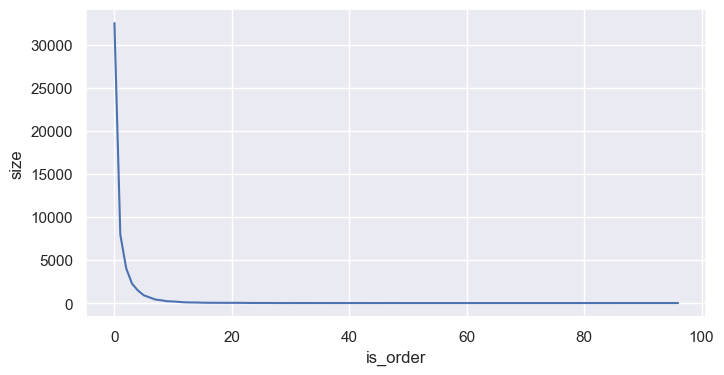

In [332]:
sns.lineplot(
    data=groupby_user.groupby("is_order", as_index=False).size().loc[:, :],
    x="is_order",
    y="size"
);

## 每件商品的点击、收藏、加购和成交量

In [333]:
groupby_item = (
    training
    .groupby("goods_id", as_index=False)[["is_click", "is_like", "is_addcart", "is_order"]]
    .sum()
)

groupby_item

,goods_id,is_click,is_like,is_addcart,is_order
0,0000023dda9f904c410105d857c6927e,16,0,0,0
1,000003b10b22b2d27df0a1a4c4505abf,6,0,3,0
2,00000983d7e3042755464d42add9c764,1,0,0,0
3,00000cf019f22a5d08cf6e4d1818abe4,1,0,0,0
4,000027e502af2eeaffdbf672ec90a708,6,0,0,0
...,...,...,...,...,...
1531521,ffffd179dfe4e14f5ca51b52e9269cbe,1,0,0,0
1531522,ffffdf0c9e67f479b8e8b545b81c52c6,7,0,0,0
1531523,ffffe146c8858f0cef9bcd81d70d8f5b,34,2,6,1
1531524,ffffe8e1352a28c47e85d49bdf3e0bb5,7,1,0,0


### 点击量

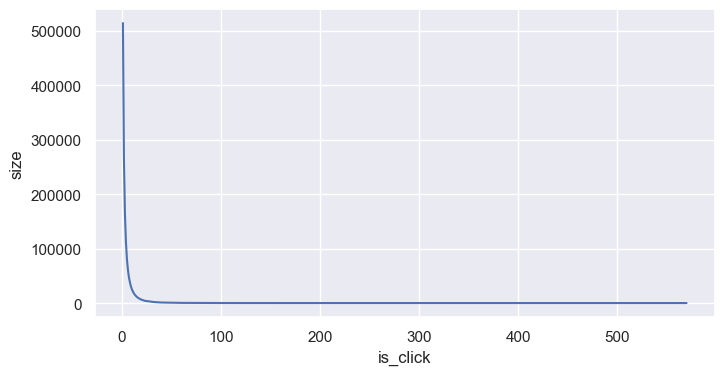

In [334]:
sns.lineplot(
    data=groupby_item.groupby("is_click", as_index=False).size().loc[:, :],
    x="is_click",
    y="size"
);

### 收藏量

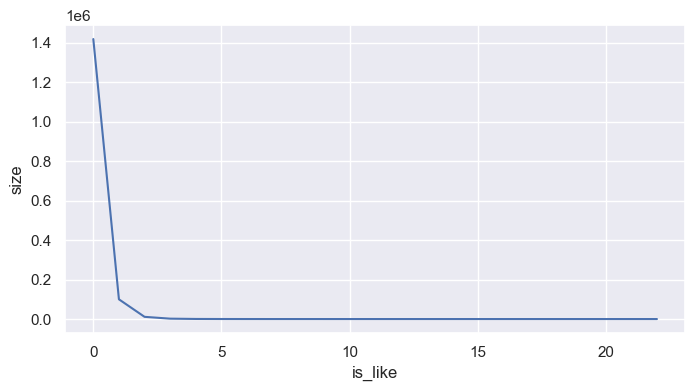

In [335]:
sns.lineplot(
    data=groupby_item.groupby("is_like", as_index=False).size().loc[:, :],
    x="is_like",
    y="size"
);

### 加购量

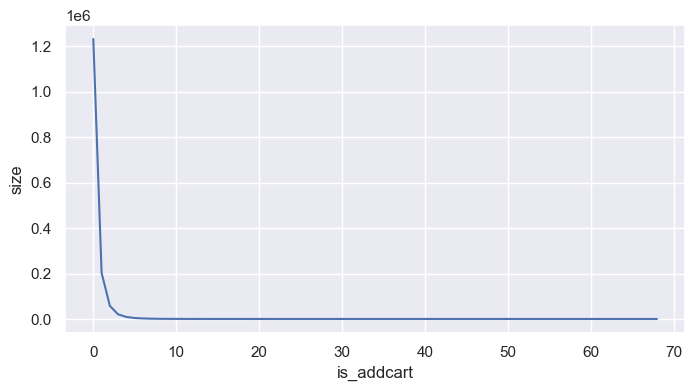

In [336]:
sns.lineplot(
    data=groupby_item.groupby("is_addcart", as_index=False).size().loc[:, :],
    x="is_addcart",
    y="size"
);

### 转化量

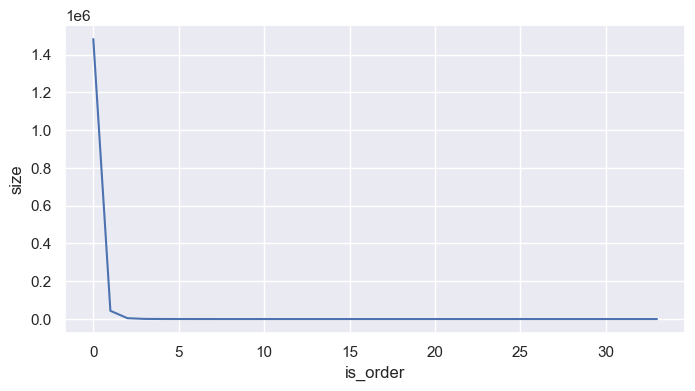

In [337]:
sns.lineplot(
    data=groupby_item.groupby("is_order", as_index=False).size().loc[:, :],
    x="is_order",
    y="size"
);

## 交叉项

### 点击-收藏分布

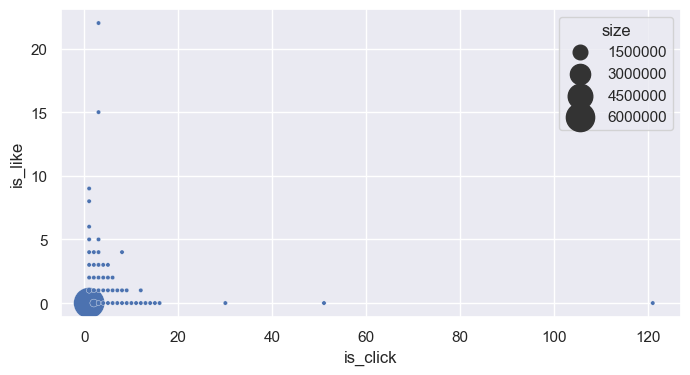

In [338]:
sns.scatterplot(
    training.groupby(["is_click", "is_like"], as_index=False).size(),
    x="is_click",
    y="is_like",
    size="size",
    sizes=(10, 500)
);

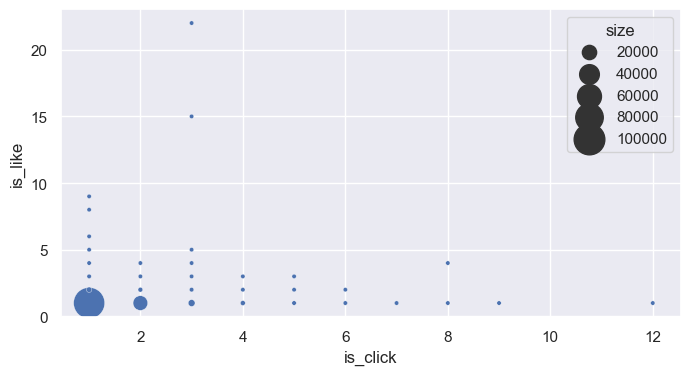

In [339]:
sns.scatterplot(
    training[training.is_like > 0].groupby(["is_click", "is_like"], as_index=False).size(),
    x="is_click",
    y="is_like",
    size="size",
    sizes=(10, 500)
);

### 点击-加购分布

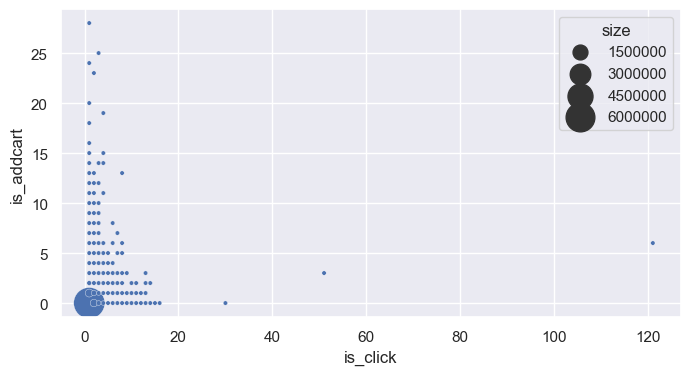

In [343]:
sns.scatterplot(
    training.groupby(["is_click", "is_addcart"], as_index=False).size(),
    x="is_click",
    y="is_addcart",
    size="size",
    sizes=(10, 500)
);

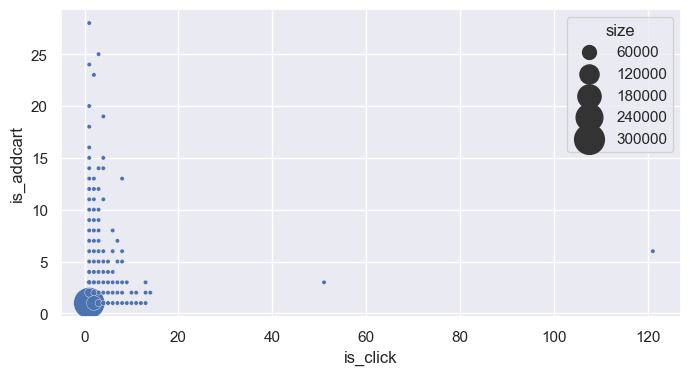

In [344]:
sns.scatterplot(
    training[training.is_addcart > 0].groupby(["is_click", "is_addcart"], as_index=False).size(),
    x="is_click",
    y="is_addcart",
    size="size",
    sizes=(10, 500)
);

### 点击-转化分布

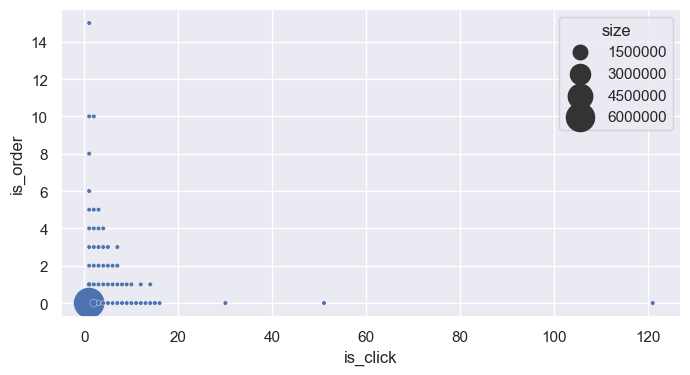

In [358]:
sns.scatterplot(
    training.groupby(["is_click", "is_order"], as_index=False).size(),
    x="is_click",
    y="is_order",
    size="size",
    sizes=(10, 500)
);

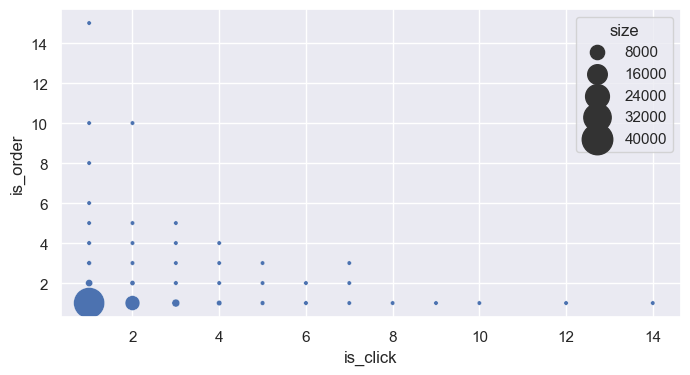

In [341]:
sns.scatterplot(
    training[training.is_order > 0].groupby(["is_click", "is_order"], as_index=False).size(),
    x="is_click",
    y="is_order",
    size="size",
    sizes=(10, 500)
);

### 加购-转化分布

In [372]:
# vip有立即购买功能
training[training.is_order > 0].groupby(["is_addcart", "is_order"], as_index=False).size()

,is_addcart,is_order,size
0,0,1,15838
1,0,2,489
2,0,3,63
3,0,4,19
4,0,5,4
5,0,6,5
6,0,10,1
7,0,15,1
8,1,1,33702
9,1,2,902


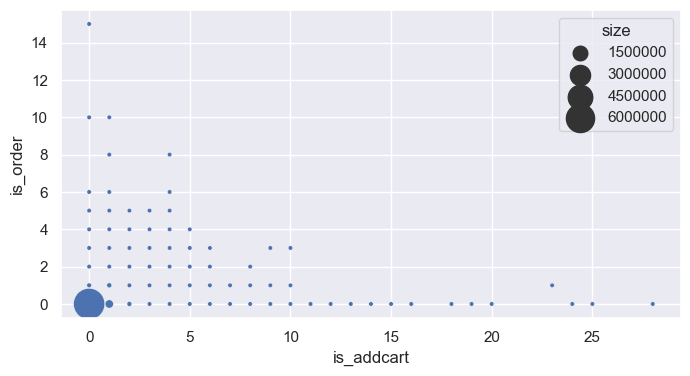

In [354]:
sns.scatterplot(
    training.groupby(["is_addcart", "is_order"], as_index=False).size(),
    x="is_addcart",
    y="is_order",
    size="size",
    sizes=(10, 500)
);

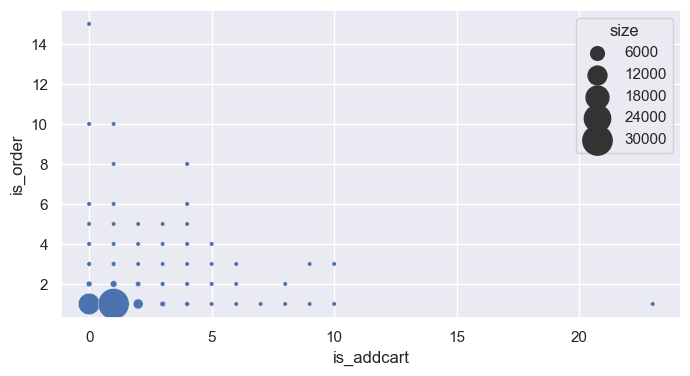

In [355]:
sns.scatterplot(
    training[training.is_order > 0].groupby(["is_addcart", "is_order"], as_index=False).size(),
    x="is_addcart",
    y="is_order",
    size="size",
    sizes=(10, 500)
);

# ItemCF

In [381]:
orders = training[training.is_order > 0].reset_index(drop=True)
orders.head()

,user_id,goods_id,is_click,is_like,is_addcart,is_order,timestamp,dt,category_id,brand_id,weekday,hour
0,70acb37d0f6db8f7a31bfa865034b5bd,760d021b13388c4f61b56170b1cdff42,1,0,0,1,2023-02-09 09:12:05,2023-02-09,bf89bef594053d560426836edd60a165,0bdf3b0901fb83181572e74dc40a108f,3,9
1,0fd9aede414f409b54a814016199cc28,b989dd2ca521143c369c3462b0b09bc4,2,0,1,1,2023-02-03 09:15:43,2023-02-03,33785bf3d5256cdecf218814f97e68f3,6a2957d85a0af94c8140d048326d1732,4,9
2,bf51e50aec1081438be298fba9eb5077,dfc184ef01cee98adf19d6bb144f6458,1,0,1,1,2023-02-16 14:06:52,2023-02-16,7e3eb4aa2680973489344ad3b561d34a,7b620e55607f518fa071114e07746c53,3,14
3,7f22cff1933a57e07d86434cf2665557,7afe1174363662a658c93676c4c5a176,1,0,1,1,2023-02-15 09:22:17,2023-02-15,63acb20f1b206dbe562ff957e9ea4ac7,6894e025508ddd0602dcce10b8d99e17,2,9
4,99922db651d72d5d2ffb29be37e651f0,7afe1174363662a658c93676c4c5a176,1,1,0,1,2023-02-23 23:51:05,2023-02-23,63acb20f1b206dbe562ff957e9ea4ac7,6894e025508ddd0602dcce10b8d99e17,3,23


In [391]:
unique_goods = list(orders["goods_id"].unique())
unique_users = list(orders["user_id"].unique())

len(unique_goods), len(unique_users)

(49449, 19066)

In [392]:
goods_id_map, users_id_map = {}, {}

for idx, good in enumerate(unique_goods):
    goods_id_map[good] = idx
    
for idx, user in enumerate(unique_users):
    users_id_map[user] = idx

In [386]:
goods_users_map = {}

for good in tqdm(unique_goods):
    curr_users = list(orders.loc[orders["goods_id"].eq(good), "user_id"].unique())
    
    goods_users_map[good] = set(curr_users)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49449/49449 [08:50<00:00, 93.25it/s]


In [404]:
user_goods_similarity = np.zeros(shape=(len(unique_users), len(unique_goods)))

user_good_order = orders.groupby(["user_id", "goods_id"], as_index=False)["is_order"].sum()
for idx, row in user_good_order.iterrows():
    curr_user_id = users_id_map[row["user_id"]]
    curr_goods_id = goods_id_map[row["goods_id"]]
    
    user_goods_similarity[curr_user_id][curr_goods_id] = row["is_order"]

In [414]:
goods_similarity = np.zeros(shape=(len(unique_goods), len(unique_goods)))
goods_ls = list(unique_goods)

for i in tqdm(range(len(goods_ls))):
    curr_i = goods_users_map[goods_ls[i]]
    idx_i = goods_id_map[goods_ls[i]]
    
    for j in range(i+1, len(goods_ls)):
        curr_j = goods_users_map[goods_ls[j]]
        idx_j = goods_id_map[goods_ls[j]]
        
        coef = len(curr_i.intersection(curr_j)) / np.sqrt(len(curr_i) * len(curr_j))
        
        goods_similarity[idx_i][idx_j] = coef
        goods_similarity[idx_j][idx_i] = coef

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49449/49449 [1:12:01<00:00, 11.44it/s]


In [ ]:
itemcf_scores = user_goods_similarity @ goods_similarity
itencf_scores.shape

# UserCF

In [ ]:
users_goods_map = {}

for user in tqdm(unique_users):
    curr_goods = list(orders.loc[orders["user_id"].eq(user), "goods_id"].unique())
    
    users_goods_map[user] = set(curr_goods)

In [ ]:
user_similarity = np.zeros(shape=(len(unique_users), len(unique_users)))
user_ls = list(unique_users)

for i in range(len(user_ls)):
    curr_i = users_goods_map[user_ls[i]]
    idx_i = users_id_map[user_ls[i]]
    
    for j in range(i+1, len(user_ls)):
        curr_j = users_goods_map[user_ls[j]]
        idx_j = users_id_map[user_ls[j]]
        
        coef = len(curr_i.intersection(curr_j)) / np.sqrt(len(curr_i) * len(curr_j))
        
        user_similarity[idx_i][idx_j] = coef
        user_similarity[idx_j][idx_i] = coef

In [ ]:
usercf_scores = user_similarity @ user_goods_similarity
usercf_scores.shape

# CF Recall Results

# Modeling

In [2]:
training = pd.read_csv("./训练集/training_data_with_features.csv")

In [3]:
training.dtypes

user_id                         int64
goods_id                        int64
is_click                        int64
is_like                         int64
is_addcart                      int64
                               ...   
category_addcart_rate_rank    float64
category_order_rate_rank      float64
max_no_like                     int64
max_no_addcart                  int64
max_no_order                    int64
Length: 143, dtype: object

## One Fold

In [4]:
train_x, test_x, train_y, test_y = train_test_split(
    training.loc[:, "dayofweek":"max_no_order"], 
    (training.loc[:, "is_order"] >= 1).astype(int), 
    test_size=0.4, 
    random_state=666
)

In [5]:
clf = lgb.LGBMClassifier(
    boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
    max_depth=-1, n_estimators=3000, objective='binary',
    subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
    learning_rate=0.01, min_child_weight=25, random_state=666, 
    n_jobs=50, early_stopping_round=10
    
)

In [6]:
clf.fit(train_x, train_y, eval_set=[(train_x,train_y), (test_x,test_y)])

[1]	training's binary_logloss: 0.0349859	valid_1's binary_logloss: 0.0349343
[2]	training's binary_logloss: 0.0323581	valid_1's binary_logloss: 0.0323125
[3]	training's binary_logloss: 0.0305389	valid_1's binary_logloss: 0.0304985
[4]	training's binary_logloss: 0.0291286	valid_1's binary_logloss: 0.0290922
[5]	training's binary_logloss: 0.0279677	valid_1's binary_logloss: 0.0279345
[6]	training's binary_logloss: 0.0269798	valid_1's binary_logloss: 0.026949
[7]	training's binary_logloss: 0.02612	valid_1's binary_logloss: 0.0260913
[8]	training's binary_logloss: 0.02573	valid_1's binary_logloss: 0.0257028
[9]	training's binary_logloss: 0.0250045	valid_1's binary_logloss: 0.0249796
[10]	training's binary_logloss: 0.0243482	valid_1's binary_logloss: 0.0243252
[11]	training's binary_logloss: 0.0237492	valid_1's binary_logloss: 0.0237278
[12]	training's binary_logloss: 0.023374	valid_1's binary_logloss: 0.0233546
[13]	training's binary_logloss: 0.0228503	valid_1's binary_logloss: 0.0228323
[

LGBMClassifier(colsample_bytree=0.7, early_stopping_round=10,
               learning_rate=0.01, min_child_weight=25, n_estimators=3000,
               n_jobs=50, objective='binary', random_state=666, reg_lambda=1,
               subsample=0.7, subsample_freq=1)

In [7]:
pred = clf.predict(test_x)

In [8]:
roc_auc_score(test_y, pred)

0.9901626626979341

In [9]:
f1_score(test_y, pred)

0.8310884811221059

In [10]:
recall_score(test_y, pred)

0.9830454545454546

In [11]:
precision_score(test_y, pred)

0.7198202695956066

## Five Fold

In [6]:
# 5-fold cross validation

kf = KFold(5, shuffle=True, random_state=666)

for i, (train_index, test_index) in enumerate(kf.split(training)):
    print(f"FOLD No.{i+1}")
    
    train_x = training.loc[train_index, "dayofweek":"max_no_order"]
    train_y = (training.loc[train_index, "is_order"] >= 1).astype(int)
    
    test_x = training.loc[test_index, "dayofweek":"max_no_order"]
    test_y = (training.loc[test_index, "is_order"] >= 1).astype(int)
    
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=-1, n_estimators=3000, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.01, min_child_weight=25, random_state=666, 
        n_jobs=50, early_stopping_round=10
    )
    
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)])
    
    pred = clf.predict(test_x)
    
    auc = roc_auc_score(test_y, pred)
    f1 = f1_score(test_y, pred)
    recall = recall_score(test_y, pred)
    precision = precision_score(test_y, pred)
    
    print(f"auc = {auc}")
    print(f"f1 = {f1}")
    print(f"recall = {recall}")
    print(f"precision = {precision}")

FOLD No.1
[1]	training's binary_logloss: 0.0352485	valid_1's binary_logloss: 0.0340578
[2]	training's binary_logloss: 0.032602	valid_1's binary_logloss: 0.0315147
[3]	training's binary_logloss: 0.03078	valid_1's binary_logloss: 0.0297672
[4]	training's binary_logloss: 0.0293628	valid_1's binary_logloss: 0.0284058
[5]	training's binary_logloss: 0.0281903	valid_1's binary_logloss: 0.0272797
[6]	training's binary_logloss: 0.0271986	valid_1's binary_logloss: 0.0263277
[7]	training's binary_logloss: 0.0263348	valid_1's binary_logloss: 0.0254977
[8]	training's binary_logloss: 0.0259429	valid_1's binary_logloss: 0.0251265
[9]	training's binary_logloss: 0.0252132	valid_1's binary_logloss: 0.0244247
[10]	training's binary_logloss: 0.0245538	valid_1's binary_logloss: 0.0237909
[11]	training's binary_logloss: 0.0239493	valid_1's binary_logloss: 0.0232096
[12]	training's binary_logloss: 0.0235736	valid_1's binary_logloss: 0.0228497
[13]	training's binary_logloss: 0.023045	valid_1's binary_logloss:

## Another API

In [7]:
train_data = lgb.Dataset(data=training.loc[:, "dayofweek":"max_no_order"], label=training.loc[:, "is_order"])

In [8]:
params = {
    "boosting_type": 'gbdt', 
    "num_leaves": 31, 
    "reg_alpha": 0.0, 
    "reg_lambda": 1,
    "max_depth": -1, 
    "n_estimators": 3000, 
    "objective": 'regression',
    "subsample": 0.7, 
    "colsample_bytree": 0.7, 
    "subsample_freq": 1,
    "learning_rate": 0.01, 
    "min_child_weight": 25, 
    "random_state": 666, 
    "n_jobs": 50
}

In [9]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=50
)

/Users/rongzhimai/Library/Caches/pypoetry/virtualenvs/vip-rec-QRKr_f0j-py3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.101645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26525
[LightGBM] [Info] Number of data points in the train set: 7791764, number of used features: 131
[LightGBM] [Info] Start training from score 0.007392
